# Counties vote

## Package import

In [153]:
import pandas as pd
from pandas.io.json import json_normalize

import seaborn as sns
from tqdm import tqdm
from time import time
from pprint import pprint
import plotly
import folium
import itertools
import graphviz
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.mlab import PCA as mlabPCA

import statsmodels.api as sm
from scipy.stats import ttest_ind

import pylab
from pandas.plotting import scatter_matrix

import xgboost as xgb
from xgboost import plot_tree

from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import requests
import json

## Utility functions

In [2]:
# Function to plot confusion matrices
# From sklearn's documentation: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def make_scatter_plot(X, name):    
    """
    Make scatterplot.

    Parameters:
    -----------
    X:a design matrix where each column is a feature and each row is an observation.
    name: the name of the plot.
    """
    pylab.clf()
    df = pd.DataFrame(X)
    axs = scatter_matrix(df, alpha=0.2, diagonal='kde')

    for ax in axs[:,0]: # the left boundary
        ax.grid('off', axis='both')
        ax.set_yticks([0, .5])

    for ax in axs[-1,:]: # the lower boundary
        ax.grid('off', axis='both')
        ax.set_xticks([0, .5])

    pylab.savefig(name + ".png")

In [4]:
# Utility function to report best scores from a grid search

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Data scraping and importing

In [5]:
# FIPS code must be read in as string, otherwise Pandas will read as numeric, and omit leading 0
votes = pd.read_csv("presidential_2008_2016.csv", dtype={'fips_code': 'str'})

pd.options.display.max_columns = 500

In [6]:
votes = votes.rename({'county': 'county_name'}, axis = "columns")

# Extracting fips_code into separate state and county codes

votes['state'] = votes.fips_code.str[0:2].astype(str)
votes['county'] = votes.fips_code.str[2:].astype(str)

In [7]:
# Fips codes are strings with leading 0's
# To sort on state fips codes, we need to create a temporary column

votes['state_temp'] = votes.state.astype(int)
votes['county_temp'] = votes.county.astype(int)

votes = votes.sort_values(by = ['state_temp', 'county_temp'], ascending = True)
votes = votes.reset_index(drop=True)

votes = votes.drop(['state_temp', 'county_temp'], axis=1)

In [8]:
# Calculating 'vote share', the percentage of the total vote received by each party

votes['dem_2008_share'] = votes.dem_2008 / votes.total_2008
votes['gop_2008_share'] = votes.gop_2008 / votes.total_2008
votes['oth_2008_share'] = votes.oth_2008 / votes.total_2008

votes['dem_2012_share'] = votes.dem_2012 / votes.total_2012
votes['gop_2012_share'] = votes.gop_2012 / votes.total_2012
votes['oth_2012_share'] = votes.oth_2012 / votes.total_2012

votes['dem_2016_share'] = votes.dem_2016 / votes.total_2016
votes['gop_2016_share'] = votes.gop_2016 / votes.total_2016
votes['oth_2016_share'] = votes.oth_2016 / votes.total_2016

In [9]:
# Calculating change in vote share for each party from election to election

votes['dem_2012_delta'] = votes.dem_2012_share - votes.dem_2008_share
votes['dem_2016_delta'] = votes.dem_2016_share - votes.dem_2012_share

votes['gop_2012_delta'] = votes.gop_2012_share - votes.gop_2008_share
votes['gop_2016_delta'] = votes.gop_2016_share - votes.gop_2012_share

In [10]:
# Winning/losing margin for each party in a given year

votes['dem_margin_2008'] = votes.dem_2008_share - votes.gop_2008_share
votes['dem_margin_2012'] = votes.dem_2012_share - votes.gop_2012_share
votes['dem_margin_2016'] = votes.dem_2016_share - votes.gop_2016_share

votes['gop_margin_2008'] = votes.gop_2008_share - votes.dem_2008_share
votes['gop_margin_2012'] = votes.gop_2012_share - votes.dem_2012_share
votes['gop_margin_2016'] = votes.gop_2016_share - votes.dem_2016_share

In [11]:
# Adding dummy variables for a win by each party

votes['dem_2008_win'] = votes.dem_2008 > votes.gop_2008
votes['dem_2012_win'] = votes.dem_2012 > votes.gop_2012
votes['dem_2016_win'] = votes.dem_2016 > votes.gop_2016

votes['gop_2008_win'] = votes.dem_2008 < votes.gop_2008
votes['gop_2012_win'] = votes.dem_2012 < votes.gop_2012
votes['gop_2016_win'] = votes.dem_2016 < votes.gop_2016

In [12]:
# Adding dummy variables for 'flipped' counties
# We can use the fact that 'False < True'

votes['dem_2012_hold'] = np.where((votes.dem_2012_win == True) & (votes.dem_2008_win == True), True, False)
votes['dem2gop_2012'] = votes.gop_2008_win < votes.gop_2012_win

votes['dem_2016_hold'] = np.where((votes.dem_2016_win == True) & (votes.dem_2012_win == True), True, False)
votes['dem2gop_2016'] = votes.gop_2012_win < votes.gop_2016_win

votes['gop_2012_hold'] = np.where((votes.gop_2012_win == True) & (votes.gop_2008_win == True), True, False)
votes['gop2dem_2012'] = votes.dem_2008_win < votes.dem_2012_win

votes['gop_2016_hold'] = np.where((votes.gop_2016_win == True) & (votes.gop_2012_win == True), True, False)
votes['gop2dem_2016'] = votes.dem_2012_win < votes.dem_2016_win

In [13]:
print('Total number of US counties:')
print(str(len(votes.county)) + '\n')

print('Number of GOP wins in 2012:')
print(str(sum(votes.gop_2012_win)))
print('Number of GOP wins in 2016:')
print(str(sum(votes.gop_2016_win)) + '\n')

print('Number of DEM to GOP flips in 2012:')
print(str(sum(votes.dem2gop_2012)))
print('Number of DEM to GOP flips in 2016:')
print(str(sum(votes.dem2gop_2016)) + '\n')

print('Number of DEM wins in 2012:')
print(str(sum(votes.dem_2012_win)))
print('Number of DEM wins in 2016:')
print(str(sum(votes.dem_2016_win)) + '\n')

print('Number of GOP to DEM flips in 2012:')
print(str(sum(votes.gop2dem_2012)))
print('Number of GOP to DEM flips in 2016:')
print(str(sum(votes.gop2dem_2016)) + '\n')

Total number of US counties:
3112

Number of GOP wins in 2012:
2426
Number of GOP wins in 2016:
2625

Number of DEM to GOP flips in 2012:
198
Number of DEM to GOP flips in 2016:
219

Number of DEM wins in 2012:
686
Number of DEM wins in 2016:
487

Number of GOP to DEM flips in 2012:
9
Number of GOP to DEM flips in 2016:
20



In [14]:
# Adding a single column "class" variable for election outcome

pd.options.mode.chained_assignment = None

votes['class_2016'] = 0

votes.class_2016[votes.dem_2016_hold == True] = 1
votes.class_2016[votes.gop2dem_2016 == True] = 2
votes.class_2016[votes.gop_2016_hold == True] = 3
votes.class_2016[votes.dem2gop_2016 == True] = 4

In [15]:
votes.class_2016.value_counts()

3    2406
1     467
4     219
2      20
Name: class_2016, dtype: int64

In [16]:
votes.shape

(3112, 50)

In [17]:
api_key = "ae8dd1c6c8d67444a17ea6707626b633671e5bba"

In [18]:
def request_parser(year, dataset, variables, county, state, api_key):
    base_url = 'https://api.census.gov/data/'
    parsed_vars = ','.join(variables)
    parsed_url = base_url + str(year) + '/' + str(dataset) + '?get=' + parsed_vars + '&for=' + 'county:' + str(county) + '&in=' + 'state:' + str(state) + "&key=" + api_key
    return(str(parsed_url))

### 2012 data call

In [19]:
acs_vars_2012 = {'NAME': 'Name',
                 'B08128_001E': 'total_employment_2012',
                 'C24050_002E': 'ag_forest_fish_hunt_mine_jobs_2012',
                 'C24050_004E': 'manufacturing_jobs_2012',
                 'B01002_001E': 'median_age_2012'                 
                }

acs_dp_vars_2012 = {'NAME': 'Name',
                    'DP02_0122E': 'total_population_2012', 
                    'DP03_0062E': 'median_household_income_2012', 
                    'DP03_0009PE': 'unemployment_rate_2012', 
                    'DP03_0003PE': 'lfp_rate_2012', #lfp = labor force participation
                    'DP02_0064PE': 'bachelor_deg_pct_2012', 
                    'DP02_0065PE': 'graduate_deg_pct_2012',
                    'DP03_0006PE': 'armed_forces_pct_2012', 
                    'DP02_0069PE': 'veteran_pct_2012', 
                    'DP03_0119PE': 'poverty_line_pct_2012', 
                    'DP05_0032PE': 'white_pct_2012', 
                    'DP05_0033PE': 'black_pct_2012', 
                    'DP05_0039PE': 'asian_pct_2012', 
                    'DP05_0066PE': 'hispanic_latino_pct_2012', 
                    'DP02_0092PE': 'foreign_born_pct_2012', 
                    'DP02_0094PE': 'naturalized_citizen_pct_2012', 
                    'DP02_0095PE': 'non_citizen_pct_2012', 
                    'DP03_0096PE': 'health_insurance_pct_2012'
                   }

vars_list_2012 = list(acs_vars_2012.keys())
vars_dp_list_2012 = list(acs_dp_vars_2012.keys())

#### Calling and cleaning ACS 2012 (main) data

In [20]:
request_str = request_parser(2012, 'acs/acs5', vars_list_2012, '*', '*', api_key)
print(request_str)

https://api.census.gov/data/2012/acs/acs5?get=NAME,B08128_001E,C24050_002E,C24050_004E,B01002_001E&for=county:*&in=state:*&key=ae8dd1c6c8d67444a17ea6707626b633671e5bba


In [21]:
api_response = requests.get(request_str)
api_rows = (json.loads(api_response.content))
header = api_rows.pop(0)

In [22]:
acs_2012 = pd.DataFrame(api_rows, columns=header)
acs_2012 = acs_2012.rename(index=str, columns=acs_vars_2012)
acs_2012['fips_code'] = acs_2012.state + acs_2012.county

In [23]:
acs_2012.iloc[:,1:-3] =  acs_2012.iloc[:,1:-3].apply(pd.to_numeric, axis = 1)

In [24]:
acs_2012['ag_forest_fish_hunt_mine_rate_2012'] = acs_2012['ag_forest_fish_hunt_mine_jobs_2012'] / acs_2012['total_employment_2012']
acs_2012['manufacturing_rate_2012'] = acs_2012['manufacturing_jobs_2012'] / acs_2012['total_employment_2012']
acs_2012 = acs_2012.drop(["ag_forest_fish_hunt_mine_jobs_2012", "manufacturing_jobs_2012"], axis=1)
acs_2012.head()

,Name,total_employment_2012,median_age_2012,state,county,fips_code,ag_forest_fish_hunt_mine_rate_2012,manufacturing_rate_2012
0,"Autauga County, Alabama",24369,37,01,001,01001,0.0141984,0.134515
1,"Baldwin County, Alabama",79588,41.2,01,003,01003,0.017377,0.0869101
2,"Barbour County, Alabama",8990,38.2,01,005,01005,0.0357063,0.244494
3,"Bibb County, Alabama",8366,39.4,01,007,01007,0.0156586,0.185513
4,"Blount County, Alabama",23117,39.1,01,009,01009,0.0308431,0.179522


In [25]:
# Dropping all data associated with Puerto Rican and Alaskan counties

acs_2012 = acs_2012[~acs_2012.Name.str.contains(", Puerto Rico")]
acs_2012 = acs_2012[~acs_2012.Name.str.contains(", Alaska")]

acs_2012.shape

(3114, 8)

#### Calling and cleaning ACS 2012 data profile (DP) data

In [26]:
request_str = request_parser(2012, 'acs/acs5/profile', vars_dp_list_2012, '*', '*', api_key)
print(request_str)

https://api.census.gov/data/2012/acs/acs5/profile?get=NAME,DP02_0122E,DP03_0062E,DP03_0009PE,DP03_0003PE,DP02_0064PE,DP02_0065PE,DP03_0006PE,DP02_0069PE,DP03_0119PE,DP05_0032PE,DP05_0033PE,DP05_0039PE,DP05_0066PE,DP02_0092PE,DP02_0094PE,DP02_0095PE,DP03_0096PE&for=county:*&in=state:*&key=ae8dd1c6c8d67444a17ea6707626b633671e5bba


In [27]:
api_response = requests.get(request_str)
api_rows = (json.loads(api_response.content))
header = api_rows.pop(0)

In [28]:
dp_2012 = pd.DataFrame(api_rows, columns=header)
dp_2012 = dp_2012.rename(index=str, columns=acs_dp_vars_2012)
dp_2012['fips_code'] = dp_2012.state + dp_2012.county

In [29]:
dp_2012.iloc[:,1:-3] =  dp_2012.iloc[:,1:-3].apply(pd.to_numeric, axis = 1)

In [30]:
for column in dp_2012.columns:
    if "pct" in column:
        dp_2012[column] = dp_2012[column] / 100
    elif "rate" in column:
        dp_2012[column] = dp_2012[column] / 100

In [31]:
dp_2012['foreign_born_citizen_2012'] = dp_2012.foreign_born_pct_2012 * (dp_2012.naturalized_citizen_pct_2012)
dp_2012['foreign_born_noncitizen_2012'] = dp_2012.foreign_born_pct_2012 * (dp_2012.non_citizen_pct_2012)

In [32]:
# Dropping all data associated with Puerto Rican and Alaskan counties

dp_2012 = dp_2012[~dp_2012.Name.str.contains(", Puerto Rico")]
dp_2012 = dp_2012[~dp_2012.Name.str.contains(", Alaska")]

dp_2012.shape

(3114, 23)

### 2016 data call

In [33]:
acs_vars_2016 = {'NAME': 'Name',
                 'B08128_001E': 'total_employment_2016',
                 'C24050_002E': 'ag_forest_fish_hunt_mine_jobs_2016',
                 'C24050_004E': 'manufacturing_jobs_2016',
                 'B01002_001E': 'median_age_2016'                 
                }

acs_dp_vars_2016 = {'NAME': 'Name',
                    'DP02_0122E': 'total_population_2016', 
                    'DP03_0062E': 'median_household_income_2016', 
                    'DP03_0009PE': 'unemployment_rate_2016', 
                    'DP03_0003PE': 'lfp_rate_2016', #lfp = labor force participation
                    'DP02_0064PE': 'bachelor_deg_pct_2016', 
                    'DP02_0065PE': 'graduate_deg_pct_2016', 
                    'DP03_0006PE': 'armed_forces_pct_2016', 
                    'DP02_0069PE': 'veteran_pct_2016', 
                    'DP03_0119PE': 'poverty_line_pct_2016', 
                    'DP05_0032PE': 'white_pct_2016',
                    'DP05_0033PE': 'black_pct_2016', 
                    'DP05_0039PE': 'asian_pct_2016', 
                    'DP05_0066PE': 'hispanic_latino_pct_2016', 
                    'DP02_0092PE': 'foreign_born_pct_2016', 
                    'DP02_0094PE': 'naturalized_citizen_pct_2016', 
                    'DP02_0095PE': 'non_citizen_pct_2016', 
                    'DP03_0096PE': 'health_insurance_pct_2016'
                   }
vars_list_2016 = list(acs_vars_2016.keys())
vars_dp_list_2016 = list(acs_dp_vars_2016.keys())

#### Calling and cleaning ACS 2016 (main) data

In [34]:
request_str = request_parser(2016, 'acs/acs5', vars_list_2016, '*', '*', api_key)
print(request_str)

https://api.census.gov/data/2016/acs/acs5?get=NAME,B08128_001E,C24050_002E,C24050_004E,B01002_001E&for=county:*&in=state:*&key=ae8dd1c6c8d67444a17ea6707626b633671e5bba


In [35]:
api_response = requests.get(request_str)
api_rows = (json.loads(api_response.content))
header = api_rows.pop(0)

In [36]:
acs_2016 = pd.DataFrame(api_rows, columns=header)
acs_2016 = acs_2016.rename(index=str, columns=acs_vars_2016)
acs_2016['fips_code'] = acs_2016.state + acs_2016.county

In [37]:
acs_2016.iloc[:,1:-3] =  acs_2016.iloc[:,1:-3].apply(pd.to_numeric, axis = 1)

In [38]:
acs_2016['ag_forest_fish_hunt_mine_rate_2016'] = acs_2016['ag_forest_fish_hunt_mine_jobs_2016'] / acs_2016['total_employment_2016']
acs_2016['manufacturing_rate_2016'] = acs_2016['manufacturing_jobs_2016'] / acs_2016['total_employment_2016']
acs_2016 = acs_2016.drop(["ag_forest_fish_hunt_mine_jobs_2016", "manufacturing_jobs_2016"], axis=1)

acs_2016.head()

,Name,total_employment_2016,median_age_2016,state,county,fips_code,ag_forest_fish_hunt_mine_rate_2016,manufacturing_rate_2016
0,"Autauga County, Alabama",24302,37.8,01,001,01001,0.0120978,0.139742
1,"Baldwin County, Alabama",86310,42.3,01,003,01003,0.0146912,0.0939173
2,"Barbour County, Alabama",8783,38.7,01,005,01005,0.0463395,0.22942
3,"Bibb County, Alabama",8280,40.2,01,007,01007,0.0394928,0.213285
4,"Blount County, Alabama",21350,40.8,01,009,01009,0.0290867,0.157471


In [39]:
# Dropping all data associated with Puerto Rican and Alaskan counties

acs_2016 = acs_2016[~acs_2016.Name.str.contains(", Puerto Rico")]
acs_2016 = acs_2016[~acs_2016.Name.str.contains(", Alaska")]

acs_2016.shape

(3113, 8)

#### Calling and cleaning ACS 2016 data profile (DP) data

In [40]:
request_str = request_parser(2016, 'acs/acs5/profile', vars_dp_list_2016, '*', '*', api_key)
print(request_str)

https://api.census.gov/data/2016/acs/acs5/profile?get=NAME,DP02_0122E,DP03_0062E,DP03_0009PE,DP03_0003PE,DP02_0064PE,DP02_0065PE,DP03_0006PE,DP02_0069PE,DP03_0119PE,DP05_0032PE,DP05_0033PE,DP05_0039PE,DP05_0066PE,DP02_0092PE,DP02_0094PE,DP02_0095PE,DP03_0096PE&for=county:*&in=state:*&key=ae8dd1c6c8d67444a17ea6707626b633671e5bba


In [41]:
api_response = requests.get(request_str)
api_rows = (json.loads(api_response.content))
header = api_rows.pop(0)

In [42]:
dp_2016 = pd.DataFrame(api_rows, columns=header)
dp_2016 = dp_2016.rename(index=str, columns=acs_dp_vars_2016)
dp_2016['fips_code'] = dp_2016.state + dp_2016.county

In [43]:
dp_2016.iloc[:,1:-3] =  dp_2016.iloc[:,1:-3].apply(pd.to_numeric, axis = 1)

In [44]:
for column in dp_2016.columns:
    if "pct" in column:
        dp_2016[column] = dp_2016[column] / 100
    elif "rate" in column:
        dp_2016[column] = dp_2016[column] / 100

In [45]:
dp_2016['foreign_born_citizen_2016'] = dp_2016.foreign_born_pct_2016 * (dp_2016.naturalized_citizen_pct_2016)
dp_2016['foreign_born_noncitizen_2016'] = dp_2016.foreign_born_pct_2016 * (dp_2016.non_citizen_pct_2016)

In [46]:
dp_2016.head()

,Name,total_population_2016,median_household_income_2016,unemployment_rate_2016,lfp_rate_2016,bachelor_deg_pct_2016,graduate_deg_pct_2016,armed_forces_pct_2016,veteran_pct_2016,poverty_line_pct_2016,white_pct_2016,black_pct_2016,asian_pct_2016,hispanic_latino_pct_2016,foreign_born_pct_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,health_insurance_pct_2016,state,county,fips_code,foreign_born_citizen_2016,foreign_born_noncitizen_2016
0,"Autauga County, Alabama",55049,53099,0.056,0.602,0.143,0.103,0.007,0.123,0.094,0.769,0.185,0.008,0.026,0.018,0.469,0.531,0.911,01,001,01001,0.008442,0.009558
1,"Baldwin County, Alabama",199510,51365,0.063,0.584,0.193,0.102,0.001,0.125,0.093,0.864,0.093,0.007,0.044,0.033,0.409,0.591,0.882,01,003,01003,0.013497,0.019503
2,"Barbour County, Alabama",26614,33956,0.128,0.48,0.078,0.051,0,0.084,0.2,0.467,0.479,0.005,0.043,0.029,0.306,0.694,0.87,01,005,01005,0.008874,0.020126
3,"Bibb County, Alabama",22572,39776,0.071,0.486,0.062,0.058,0,0.072,0.117,0.77,0.212,0.001,0.022,0.014,0.256,0.744,0.91,01,007,01007,0.003584,0.010416
4,"Blount County, Alabama",57704,46212,0.06,0.499,0.089,0.041,0,0.101,0.122,0.954,0.016,0.002,0.087,0.043,0.279,0.721,0.888,01,009,01009,0.011997,0.031003


In [47]:
# Dropping all data associated with Puerto Rican and Alaskan counties

dp_2016 = dp_2016[~dp_2016.Name.str.contains(", Puerto Rico")]
dp_2016 = dp_2016[~dp_2016.Name.str.contains(", Alaska")]

dp_2016.shape

(3113, 23)

## Merging data

In [48]:
combined_2012 = pd.merge(acs_2012, dp_2012, how="inner")
combined_2016 = pd.merge(acs_2016, dp_2016, how="inner")

In [49]:
cols = combined_2012.columns.difference(votes.columns)
votes_combined = votes.join(combined_2012[cols])

cols = combined_2016.columns.difference(votes_combined.columns)
votes_combined = votes_combined.join(combined_2016[cols])

votes_combined.head()

,fips_code,county_name,total_2008,dem_2008,gop_2008,oth_2008,total_2012,dem_2012,gop_2012,oth_2012,total_2016,dem_2016,gop_2016,oth_2016,state,county,dem_2008_share,gop_2008_share,oth_2008_share,dem_2012_share,gop_2012_share,oth_2012_share,dem_2016_share,gop_2016_share,oth_2016_share,dem_2012_delta,dem_2016_delta,gop_2012_delta,gop_2016_delta,dem_margin_2008,dem_margin_2012,dem_margin_2016,gop_margin_2008,gop_margin_2012,gop_margin_2016,dem_2008_win,dem_2012_win,dem_2016_win,gop_2008_win,gop_2012_win,gop_2016_win,dem_2012_hold,dem2gop_2012,dem_2016_hold,dem2gop_2016,gop_2012_hold,gop2dem_2012,gop_2016_hold,gop2dem_2016,class_2016,Name,ag_forest_fish_hunt_mine_rate_2012,armed_forces_pct_2012,asian_pct_2012,bachelor_deg_pct_2012,black_pct_2012,foreign_born_citizen_2012,foreign_born_noncitizen_2012,foreign_born_pct_2012,graduate_deg_pct_2012,health_insurance_pct_2012,hispanic_latino_pct_2012,lfp_rate_2012,manufacturing_rate_2012,median_age_2012,median_household_income_2012,naturalized_citizen_pct_2012,non_citizen_pct_2012,poverty_line_pct_2012,total_employment_2012,total_population_2012,unemployment_rate_2012,veteran_pct_2012,white_pct_2012,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_employment_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016
0,01001,Autauga County,23641,6093,17403,145,23909,6354,17366,189,24661,5908,18110,643,01,001,0.257730,0.736136,0.006133,0.265758,0.726337,0.007905,0.239569,0.734358,0.026074,0.008027,-0.026189,-0.009799,0.008021,-0.478406,-0.460580,-0.494789,0.478406,0.460580,0.494789,False,False,False,True,True,True,False,False,False,False,True,False,True,False,3,"Autauga County, Alabama",0.0141984,0.017,0.008,0.145,0.181,0.004942,0.009058,0.014,0.072,0.904,0.024,0.631,0.134515,37,53773,0.353,0.647,0.074,24369,54590,0.086,0.154,0.789,0.0120978,0.007,0.008,0.143,0.185,0.008442,0.009558,0.018,0.103,0.911,0.026,0.602,0.139742,37.8,53099,0.469,0.531,0.094,24302,55049,0.056,0.123,0.769
1,01003,Baldwin County,81413,19386,61271,756,84988,18329,65772,887,94090,18409,72780,2901,01,003,0.238119,0.752595,0.009286,0.215666,0.773897,0.010437,0.195653,0.773515,0.030832,-0.022453,-0.020013,0.021303,-0.000383,-0.514476,-0.558232,-0.577862,0.514476,0.558232,0.577862,False,False,False,True,True,True,False,False,False,False,True,False,True,False,3,"Baldwin County, Alabama",0.017377,0.002,0.007,0.187,0.093,0.011285,0.025715,0.037,0.09,0.855,0.043,0.607,0.0869101,41.2,50706,0.305,0.695,0.096,79588,183226,0.085,0.141,0.864,0.0146912,0.001,0.007,0.193,0.093,0.013497,0.019503,0.033,0.102,0.882,0.044,0.584,0.0939173,42.3,51365,0.409,0.591,0.093,86310,199510,0.063,0.125,0.864
2,01005,Barbour County,11630,5697,5866,67,11459,5873,5539,47,10390,4848,5431,111,01,005,0.489854,0.504385,0.005761,0.512523,0.483376,0.004102,0.466603,0.522714,0.010683,0.022669,-0.045920,-0.021010,0.039339,-0.014531,0.029147,-0.056112,0.014531,-0.029147,0.056112,False,True,False,True,False,True,False,False,False,True,False,True,False,False,4,"Barbour County, Alabama",0.0357063,0,0.008,0.085,0.46,0.00546,0.02254,0.028,0.06,0.831,0.05,0.479,0.244494,38.2,31889,0.195,0.805,0.202,8990,27469,0.135,0.101,0.49,0.0463395,0,0.005,0.078,0.479,0.008874,0.020126,0.029,0.051,0.87,0.043,0.48,0.22942,38.7,33956,0.306,0.694,0.2,8783,26614,0.128,0.084,0.467
3,01007,Bibb County,8644,2299,6262,83,8391,2200,6131,60,8748,1874,6733,141,01,007,0.265965,0.724433,0.009602,0.262186,0.730664,0.007151,0.214220,0.769662,0.016118,-0.003779,-0.047965,0.006231,0.038998,-0.458468,-0.468478,-0.555441,0.458468,0.468478,0.555441,False,False,False,True,True,True,False,False,False,False,True,Fals

In [50]:
votes_combined = votes_combined.drop(['total_employment_2012','total_employment_2016'], 1)

In [51]:
np.seterr(invalid='ignore')

votes_combined['median_household_income_2012'] = np.log10(votes_combined['median_household_income_2012'].astype(int))
votes_combined['median_household_income_2016'] = np.log10(votes_combined['median_household_income_2016'].astype(int))

votes_combined['total_population_2012'] = np.log10(votes_combined['total_population_2012'].astype(int))
votes_combined['total_population_2016'] = np.log10(votes_combined['total_population_2016'].astype(int))

In [52]:
votes_combined.shape

(3112, 95)

## Creating delta/change columns

In [53]:
votes_combined.head()

,fips_code,county_name,total_2008,dem_2008,gop_2008,oth_2008,total_2012,dem_2012,gop_2012,oth_2012,total_2016,dem_2016,gop_2016,oth_2016,state,county,dem_2008_share,gop_2008_share,oth_2008_share,dem_2012_share,gop_2012_share,oth_2012_share,dem_2016_share,gop_2016_share,oth_2016_share,dem_2012_delta,dem_2016_delta,gop_2012_delta,gop_2016_delta,dem_margin_2008,dem_margin_2012,dem_margin_2016,gop_margin_2008,gop_margin_2012,gop_margin_2016,dem_2008_win,dem_2012_win,dem_2016_win,gop_2008_win,gop_2012_win,gop_2016_win,dem_2012_hold,dem2gop_2012,dem_2016_hold,dem2gop_2016,gop_2012_hold,gop2dem_2012,gop_2016_hold,gop2dem_2016,class_2016,Name,ag_forest_fish_hunt_mine_rate_2012,armed_forces_pct_2012,asian_pct_2012,bachelor_deg_pct_2012,black_pct_2012,foreign_born_citizen_2012,foreign_born_noncitizen_2012,foreign_born_pct_2012,graduate_deg_pct_2012,health_insurance_pct_2012,hispanic_latino_pct_2012,lfp_rate_2012,manufacturing_rate_2012,median_age_2012,median_household_income_2012,naturalized_citizen_pct_2012,non_citizen_pct_2012,poverty_line_pct_2012,total_population_2012,unemployment_rate_2012,veteran_pct_2012,white_pct_2012,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016
0,01001,Autauga County,23641,6093,17403,145,23909,6354,17366,189,24661,5908,18110,643,01,001,0.257730,0.736136,0.006133,0.265758,0.726337,0.007905,0.239569,0.734358,0.026074,0.008027,-0.026189,-0.009799,0.008021,-0.478406,-0.460580,-0.494789,0.478406,0.460580,0.494789,False,False,False,True,True,True,False,False,False,False,True,False,True,False,3,"Autauga County, Alabama",0.0141984,0.017,0.008,0.145,0.181,0.004942,0.009058,0.014,0.072,0.904,0.024,0.631,0.134515,37,4.730564,0.353,0.647,0.074,4.737113,0.086,0.154,0.789,0.0120978,0.007,0.008,0.143,0.185,0.008442,0.009558,0.018,0.103,0.911,0.026,0.602,0.139742,37.8,4.725086,0.469,0.531,0.094,4.740749,0.056,0.123,0.769
1,01003,Baldwin County,81413,19386,61271,756,84988,18329,65772,887,94090,18409,72780,2901,01,003,0.238119,0.752595,0.009286,0.215666,0.773897,0.010437,0.195653,0.773515,0.030832,-0.022453,-0.020013,0.021303,-0.000383,-0.514476,-0.558232,-0.577862,0.514476,0.558232,0.577862,False,False,False,True,True,True,False,False,False,False,True,False,True,False,3,"Baldwin County, Alabama",0.017377,0.002,0.007,0.187,0.093,0.011285,0.025715,0.037,0.09,0.855,0.043,0.607,0.0869101,41.2,4.705059,0.305,0.695,0.096,5.262987,0.085,0.141,0.864,0.0146912,0.001,0.007,0.193,0.093,0.013497,0.019503,0.033,0.102,0.882,0.044,0.584,0.0939173,42.3,4.710667,0.409,0.591,0.093,5.299965,0.063,0.125,0.864
2,01005,Barbour County,11630,5697,5866,67,11459,5873,5539,47,10390,4848,5431,111,01,005,0.489854,0.504385,0.005761,0.512523,0.483376,0.004102,0.466603,0.522714,0.010683,0.022669,-0.045920,-0.021010,0.039339,-0.014531,0.029147,-0.056112,0.014531,-0.029147,0.056112,False,True,False,True,False,True,False,False,False,True,False,True,False,False,4,"Barbour County, Alabama",0.0357063,0,0.008,0.085,0.46,0.00546,0.02254,0.028,0.06,0.831,0.05,0.479,0.244494,38.2,4.503641,0.195,0.805,0.202,4.438843,0.135,0.101,0.49,0.0463395,0,0.005,0.078,0.479,0.008874,0.020126,0.029,0.051,0.87,0.043,0.48,0.22942,38.7,4.530917,0.306,0.694,0.2,4.425110,0.128,0.084,0.467
3,01007,Bibb County,8644,2299,6262,83,8391,2200,6131,60,8748,1874,6733,141,01,007,0.265965,0.724433,0.009602,0.262186,0.730664,0.007151,0.214220,0.769662,0.016118,-0.003779,-0.047965,0.006231,0.038998,-0.458468,-0.468478,-0.555441,0.458468,0.468478,0.555441,False,False,False,True,True,True,False,False,False,False,True,False,True,False,3,"Bibb County, Alabama",0.0156

In [54]:
# ag_forest_fish_hunt_mine_rate is the first column (alphabetically) for both the 2012 and 2016 data
# We find each column's index here

print(votes_combined.columns.get_loc('ag_forest_fish_hunt_mine_rate_2012'))
print(votes_combined.columns.get_loc('ag_forest_fish_hunt_mine_rate_2016'))

51
73


In [55]:
for column in votes_combined.columns[73:]:
    index_2016 = votes_combined.columns.get_loc(column)
    column_2012 = votes_combined.columns[index_2016 - 22]
    temp_str = column[:-4] + '12-16_delta'
    votes_combined[temp_str] = votes_combined[column].values - votes_combined[column_2012].values

In [56]:
votes_combined.head()

,fips_code,county_name,total_2008,dem_2008,gop_2008,oth_2008,total_2012,dem_2012,gop_2012,oth_2012,total_2016,dem_2016,gop_2016,oth_2016,state,county,dem_2008_share,gop_2008_share,oth_2008_share,dem_2012_share,gop_2012_share,oth_2012_share,dem_2016_share,gop_2016_share,oth_2016_share,dem_2012_delta,dem_2016_delta,gop_2012_delta,gop_2016_delta,dem_margin_2008,dem_margin_2012,dem_margin_2016,gop_margin_2008,gop_margin_2012,gop_margin_2016,dem_2008_win,dem_2012_win,dem_2016_win,gop_2008_win,gop_2012_win,gop_2016_win,dem_2012_hold,dem2gop_2012,dem_2016_hold,dem2gop_2016,gop_2012_hold,gop2dem_2012,gop_2016_hold,gop2dem_2016,class_2016,Name,ag_forest_fish_hunt_mine_rate_2012,armed_forces_pct_2012,asian_pct_2012,bachelor_deg_pct_2012,black_pct_2012,foreign_born_citizen_2012,foreign_born_noncitizen_2012,foreign_born_pct_2012,graduate_deg_pct_2012,health_insurance_pct_2012,hispanic_latino_pct_2012,lfp_rate_2012,manufacturing_rate_2012,median_age_2012,median_household_income_2012,naturalized_citizen_pct_2012,non_citizen_pct_2012,poverty_line_pct_2012,total_population_2012,unemployment_rate_2012,veteran_pct_2012,white_pct_2012,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016,ag_forest_fish_hunt_mine_rate_12-16_delta,armed_forces_pct_12-16_delta,asian_pct_12-16_delta,bachelor_deg_pct_12-16_delta,black_pct_12-16_delta,foreign_born_citizen_12-16_delta,foreign_born_noncitizen_12-16_delta,foreign_born_pct_12-16_delta,graduate_deg_pct_12-16_delta,health_insurance_pct_12-16_delta,hispanic_latino_pct_12-16_delta,lfp_rate_12-16_delta,manufacturing_rate_12-16_delta,median_age_12-16_delta,median_household_income_12-16_delta,naturalized_citizen_pct_12-16_delta,non_citizen_pct_12-16_delta,poverty_line_pct_12-16_delta,total_population_12-16_delta,unemployment_rate_12-16_delta,veteran_pct_12-16_delta,white_pct_12-16_delta
0,01001,Autauga County,23641,6093,17403,145,23909,6354,17366,189,24661,5908,18110,643,01,001,0.257730,0.736136,0.006133,0.265758,0.726337,0.007905,0.239569,0.734358,0.026074,0.008027,-0.026189,-0.009799,0.008021,-0.478406,-0.460580,-0.494789,0.478406,0.460580,0.494789,False,False,False,True,True,True,False,False,False,False,True,False,True,False,3,"Autauga County, Alabama",0.0141984,0.017,0.008,0.145,0.181,0.004942,0.009058,0.014,0.072,0.904,0.024,0.631,0.134515,37,4.730564,0.353,0.647,0.074,4.737113,0.086,0.154,0.789,0.0120978,0.007,0.008,0.143,0.185,0.008442,0.009558,0.018,0.103,0.911,0.026,0.602,0.139742,37.8,4.725086,0.469,0.531,0.094,4.740749,0.056,0.123,0.769,-0.0021006,-0.01,0,-0.002,0.004,0.0035,0.0005,0.004,0.031,0.007,0.002,-0.029,0.00522642,0.8,-0.005478,0.116,-0.116,0.02,0.003636,-0.03,-0.031,-0.02
1,01003,Baldwin County,81413,19386,61271,756,84988,18329,65772,887,94090,18409,72780,2901,01,003,0.238119,0.752595,0.009286,0.215666,0.773897,0.010437,0.195653,0.773515,0.030832,-0.022453,-0.020013,0.021303,-0.000383,-0.514476,-0.558232,-0.577862,0.514476,0.558232,0.577862,False,False,False,True,True,True,False,False,False,False,True,False,True,False,3,"Baldwin County, Alabama",0.017377,0.002,0.007,0.187,0.093,0.011285,0.025715,0.037,0.09,0.855,0.043,0.607,0.0869101,41.2,4.705059,0.305,0.695,0.096,5.262987,0.085,0.141,0.864,0.0146912,0.001,0.007,0.193,0.093,0.013497,0.019503,0.033,0.102,0.882,0.044,0.584,0.0939173,42.3,4.710667,0.409,0.591,0.093,5.299965,0.063,0.125,0.864,-0.00268576,-0.001,0,0.006,0,0.002212,-0.006212,-0.004,0.012,0.027,0.001,-0.023,0.00700719,1.1,0.005608,0.104,-0.104,-0.003,0.036978,-0.022,-0.016,0
2,01005,Barbour County,11630,5697,5866,67,11459,5873,5539,47,10390,4848,5431,1

In [57]:
print(votes_combined.columns.get_loc('ag_forest_fish_hunt_mine_rate_12-16_delta'))
print(votes_combined.columns.get_loc('white_pct_12-16_delta'))

95
116


In [58]:
print(votes_combined.columns.get_loc('ag_forest_fish_hunt_mine_rate_2016'))
print(votes_combined.columns.get_loc('white_pct_2016'))

73
94


In [59]:
print(votes_combined.columns.get_loc('dem_margin_2012'))
print(votes_combined.columns.get_loc('gop_margin_2012'))
print(votes_combined.columns.get_loc('dem_2016_delta'))
print(votes_combined.columns.get_loc('gop_2016_delta'))
print(votes_combined.columns.get_loc('class_2016'))

30
33
26
28
49


In [60]:
votes_deltas = votes_combined.iloc[:, np.r_[0, 26, 28, 30, 33, 49, 95:117]]
votes_deltas.head()

,fips_code,dem_2016_delta,gop_2016_delta,dem_margin_2012,gop_margin_2012,class_2016,ag_forest_fish_hunt_mine_rate_12-16_delta,armed_forces_pct_12-16_delta,asian_pct_12-16_delta,bachelor_deg_pct_12-16_delta,black_pct_12-16_delta,foreign_born_citizen_12-16_delta,foreign_born_noncitizen_12-16_delta,foreign_born_pct_12-16_delta,graduate_deg_pct_12-16_delta,health_insurance_pct_12-16_delta,hispanic_latino_pct_12-16_delta,lfp_rate_12-16_delta,manufacturing_rate_12-16_delta,median_age_12-16_delta,median_household_income_12-16_delta,naturalized_citizen_pct_12-16_delta,non_citizen_pct_12-16_delta,poverty_line_pct_12-16_delta,total_population_12-16_delta,unemployment_rate_12-16_delta,veteran_pct_12-16_delta,white_pct_12-16_delta
0,01001,-0.026189,0.008021,-0.460580,0.460580,3,-0.0021006,-0.01,0,-0.002,0.004,0.0035,0.0005,0.004,0.031,0.007,0.002,-0.029,0.00522642,0.8,-0.005478,0.116,-0.116,0.02,0.003636,-0.03,-0.031,-0.02
1,01003,-0.020013,-0.000383,-0.558232,0.558232,3,-0.00268576,-0.001,0,0.006,0,0.002212,-0.006212,-0.004,0.012,0.027,0.001,-0.023,0.00700719,1.1,0.005608,0.104,-0.104,-0.003,0.036978,-0.022,-0.016,0
2,01005,-0.045920,0.039339,0.029147,-0.029147,4,0.0106332,0,-0.003,-0.007,0.019,0.003414,-0.002414,0.001,-0.009,0.039,-0.007,0.001,-0.0150734,0.5,0.027276,0.111,-0.111,-0.002,-0.013733,-0.007,-0.017,-0.023
3,01007,-0.047965,0.038998,-0.468478,0.468478,3,0.0238341,0,0,0.002,-0.006,-0.002487,0.003487,0.001,0.028,0.058,0.004,-0.044,0.0277722,0.8,0.033490,-0.211,0.211,-0.014,-0.003774,-0.034,-0.022,0.003
4,01009,-0.038779,0.033590,-0.741451,0.741451,3,-0.00175645,0,0,0.008,0.003,0.004383,-0.008383,-0.004,-0.002,0.019,0.006,-0.083,-0.0220508,1.7,0.009693,0.117,-0.117,0.013,0.001795,-0.04,0.003,0.005


In [61]:
vitals_2016 = votes_combined.iloc[:, np.r_[0, 73:95]]
vitals_2016.head()

,fips_code,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016
0,01001,0.0120978,0.007,0.008,0.143,0.185,0.008442,0.009558,0.018,0.103,0.911,0.026,0.602,0.139742,37.8,4.725086,0.469,0.531,0.094,4.740749,0.056,0.123,0.769
1,01003,0.0146912,0.001,0.007,0.193,0.093,0.013497,0.019503,0.033,0.102,0.882,0.044,0.584,0.0939173,42.3,4.710667,0.409,0.591,0.093,5.299965,0.063,0.125,0.864
2,01005,0.0463395,0,0.005,0.078,0.479,0.008874,0.020126,0.029,0.051,0.87,0.043,0.48,0.22942,38.7,4.530917,0.306,0.694,0.2,4.425110,0.128,0.084,0.467
3,01007,0.0394928,0,0.001,0.062,0.212,0.003584,0.010416,0.014,0.058,0.91,0.022,0.486,0.213285,40.2,4.599621,0.256,0.744,0.117,4.353570,0.071,0.072,0.77
4,01009,0.0290867,0,0.002,0.089,0.016,0.011997,0.031003,0.043,0.041,0.888,0.087,0.499,0.157471,40.8,4.664755,0.279,0.721,0.122,4.761206,0.06,0.101,0.954


In [62]:
vitals_deltas_2016 = pd.merge(votes_deltas, vitals_2016, how="inner")
vitals_deltas_2016.head()

,fips_code,dem_2016_delta,gop_2016_delta,dem_margin_2012,gop_margin_2012,class_2016,ag_forest_fish_hunt_mine_rate_12-16_delta,armed_forces_pct_12-16_delta,asian_pct_12-16_delta,bachelor_deg_pct_12-16_delta,black_pct_12-16_delta,foreign_born_citizen_12-16_delta,foreign_born_noncitizen_12-16_delta,foreign_born_pct_12-16_delta,graduate_deg_pct_12-16_delta,health_insurance_pct_12-16_delta,hispanic_latino_pct_12-16_delta,lfp_rate_12-16_delta,manufacturing_rate_12-16_delta,median_age_12-16_delta,median_household_income_12-16_delta,naturalized_citizen_pct_12-16_delta,non_citizen_pct_12-16_delta,poverty_line_pct_12-16_delta,total_population_12-16_delta,unemployment_rate_12-16_delta,veteran_pct_12-16_delta,white_pct_12-16_delta,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016
0,01001,-0.026189,0.008021,-0.460580,0.460580,3,-0.0021006,-0.01,0,-0.002,0.004,0.0035,0.0005,0.004,0.031,0.007,0.002,-0.029,0.00522642,0.8,-0.005478,0.116,-0.116,0.02,0.003636,-0.03,-0.031,-0.02,0.0120978,0.007,0.008,0.143,0.185,0.008442,0.009558,0.018,0.103,0.911,0.026,0.602,0.139742,37.8,4.725086,0.469,0.531,0.094,4.740749,0.056,0.123,0.769
1,01003,-0.020013,-0.000383,-0.558232,0.558232,3,-0.00268576,-0.001,0,0.006,0,0.002212,-0.006212,-0.004,0.012,0.027,0.001,-0.023,0.00700719,1.1,0.005608,0.104,-0.104,-0.003,0.036978,-0.022,-0.016,0,0.0146912,0.001,0.007,0.193,0.093,0.013497,0.019503,0.033,0.102,0.882,0.044,0.584,0.0939173,42.3,4.710667,0.409,0.591,0.093,5.299965,0.063,0.125,0.864
2,01005,-0.045920,0.039339,0.029147,-0.029147,4,0.0106332,0,-0.003,-0.007,0.019,0.003414,-0.002414,0.001,-0.009,0.039,-0.007,0.001,-0.0150734,0.5,0.027276,0.111,-0.111,-0.002,-0.013733,-0.007,-0.017,-0.023,0.0463395,0,0.005,0.078,0.479,0.008874,0.020126,0.029,0.051,0.87,0.043,0.48,0.22942,38.7,4.530917,0.306,0.694,0.2,4.425110,0.128,0.084,0.467
3,01007,-0.047965,0.038998,-0.468478,0.468478,3,0.0238341,0,0,0.002,-0.006,-0.002487,0.003487,0.001,0.028,0.058,0.004,-0.044,0.0277722,0.8,0.033490,-0.211,0.211,-0.014,-0.003774,-0.034,-0.022,0.003,0.0394928,0,0.001,0.062,0.212,0.003584,0.010416,0.014,0.058,0.91,0.022,0.486,0.213285,40.2,4.599621,0.256,0.744,0.117,4.353570,0.071,0.072,0.77
4,01009,-0.038779,0.033590,-0.741451,0.741451,3,-0.00175645,0,0,0.008,0.003,0.004383,-0.008383,-0.004,-0.002,0.019,0.006,-0.083,-0.0220508,1.7,0.009693,0.117,-0.117,0.013,0.001795,-0.04,0.003,0.005,0.0290867,0,0.002,0.089,0.016,0.011997,0.031003,0.043,0.041,0.888,0.087,0.499,0.157471,40.8,4.664755,0.279,0.721,0.122,4.761206,0.06,0.101,0.954


## Predicting change in vote share (regression)

### Linear Regression

In [63]:
X2 = vitals_deltas_2016.drop(['fips_code', 'dem_2016_delta', 'class_2016'] , 1)
Y2 = vitals_deltas_2016['dem_2016_delta']
# X2 = X.dropna(axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.30, random_state=42)

linreg = sm.OLS(Y_train2, X_train2.astype(float)).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         dem_2016_delta   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1067.
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:42:10   Log-Likelihood:                 5745.6
No. Observations:                2178   AIC:                        -1.140e+04
Df Residuals:                    2132   BIC:                        -1.114e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
gop_2016_delta                               -0.7256      0.008    -86.467      0.000      -0.742      -0.709
dem_margin_2012                              -0.0123      0.001    -14.543      0.000      -0.014      -0.011
gop_margin_2012                               0.0121      0.001     14.256      0.000       0.010       0.014
ag_forest_fish_hunt_mine_rate_12-16_delta     0.0029      0.008      0.340      0.734      -0.014       0.019
armed_forces_pct_12-16_delta                  0.0784      0.038      2.078      0.038       0.004       0.152
asian_pct_12-16_delta                         0.0056      0.026      0.215      0.830      -0.045       0.056
bachelor_deg_pct_12-16_delta                 -0.0094      0.015     -0.648      0.517      -0.038       0.019
black_pct_12-16_delta                         0.0046      0.006      0.826      0.409      -0.006       0.016
foreign_born_citizen_12-16_delta           -218.2850    272.057     -0.802      0.422    -751.809     315.239
foreign_born_noncitizen_12-16_delta        -218.3251    272.057     -0.802      0.422    -751.850     315.200
foreign_born_pct_12-16_delta                218.2984    272.057      0.802      0.422    -315.226     751.823
graduate_deg_pct_12-16_delta                  0.0110      0.018      0.628      0.530      -0.023       0.045
health_insurance_pct_12-16_delta              0.0197      0.011      1.832      0.067      -0.001       0.041
hispanic_latino_pct_12-16_delta              -0.0042      0.005     -0.824      0.410      -0.014       0.006
lfp_rate_12-16_delta                         -0.0062      0.009     -0.708      0.479      -0.023       0.011
manufacturing_rate_12-16_delta                0.0060      0.008      0.782      0.435      -0.009       0.021
median_age_12-16_delta                     7.739e-05      0.000      0.612      0.541      -0.000       0.000
median_household_income_12-16_delta           0.0176      0.006      2.781      0.005       0.005       0.030
naturalized_citizen_pct_12-16_delta          -0.0016      0.001     -1.249      0.212      -0.004       0.001
non_citizen_pct_12-16_delta                   0.0016      0.001      1.249      0.212      -0.001       0.004
poverty_line_pct_12-16_delta                  0.0422      0.014      2.981      0.003       0.014       0.070
total_population_12-16_delta                 -0.0017      0.001     -1.583      0.114      -0.004       0.000
unemployment_rate_12-16_delta                 0.0107      0.015      0.689      0.491      -0.020       0.041
veteran_pct_12-16_delta                      -0.0658      0.022     -3.021      0.003      -0.108      -0.023
white_pct_12-16_delta                         0.0135      0.006      2.415      0.016       0.003       0.024
ag_

In [64]:
linreg_pred = linreg.predict(X_test2)

In [65]:
len(linreg_pred)

934

In [66]:
r2_score(Y_test2, linreg_pred)

0.8593868510990124

In [67]:
X2 = vitals_deltas_2016.drop(['fips_code', 'dem_2016_delta', 'class_2016'] , 1)
Y2 = vitals_deltas_2016['dem_2016_delta']
# X2 = X.dropna(axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.30, random_state=42)

linreg_full = sm.OLS(Y2, X2.astype(float)).fit()
linreg_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         dem_2016_delta   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1433.
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:42:13   Log-Likelihood:                 8136.9
No. Observations:                3112   AIC:                        -1.618e+04
Df Residuals:                    3066   BIC:                        -1.590e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
gop_2016_delta                               -0.7261      0.007   -101.098      0.000      -0.740      -0.712
dem_margin_2012                              -0.0093      0.003     -3.213      0.001      -0.015      -0.004
gop_margin_2012                               0.0130      0.003      4.491      0.000       0.007       0.019
ag_forest_fish_hunt_mine_rate_12-16_delta     0.0037      0.007      0.515      0.607      -0.010       0.018
armed_forces_pct_12-16_delta                  0.0336      0.026      1.285      0.199      -0.018       0.085
asian_pct_12-16_delta                         0.0050      0.023      0.216      0.829      -0.041       0.051
bachelor_deg_pct_12-16_delta                 -0.0125      0.012     -1.022      0.307      -0.037       0.011
black_pct_12-16_delta                         0.0068      0.005      1.343      0.179      -0.003       0.017
foreign_born_citizen_12-16_delta           -191.6177    274.345     -0.698      0.485    -729.536     346.300
foreign_born_noncitizen_12-16_delta        -191.6326    274.345     -0.699      0.485    -729.551     346.286
foreign_born_pct_12-16_delta                191.6172    274.345      0.698      0.485    -346.301     729.535
graduate_deg_pct_12-16_delta                  0.0137      0.015      0.925      0.355      -0.015       0.043
health_insurance_pct_12-16_delta              0.0259      0.009      2.856      0.004       0.008       0.044
hispanic_latino_pct_12-16_delta              -0.0015      0.004     -0.353      0.724      -0.010       0.007
lfp_rate_12-16_delta                         -0.0071      0.007     -0.980      0.327      -0.021       0.007
manufacturing_rate_12-16_delta                0.0110      0.007      1.688      0.092      -0.002       0.024
median_age_12-16_delta                    -2.154e-05      0.000     -0.201      0.841      -0.000       0.000
median_household_income_12-16_delta           0.0128      0.005      2.375      0.018       0.002       0.023
naturalized_citizen_pct_12-16_delta           0.0005      0.001      0.458      0.647      -0.002       0.002
non_citizen_pct_12-16_delta                  -0.0005      0.001     -0.458      0.647      -0.002       0.002
poverty_line_pct_12-16_delta                  0.0422      0.012      3.542      0.000       0.019       0.066
total_population_12-16_delta                 -0.0015      0.001     -1.683      0.093      -0.003       0.000
unemployment_rate_12-16_delta                 0.0057      0.013      0.433      0.665      -0.020       0.032
veteran_pct_12-16_delta                      -0.0464      0.018     -2.650      0.008      -0.081      -0.012
white_pct_12-16_delta                         0.0139      0.005      2.747      0.006       0.004       0.024
ag_

### Random Forest Regression

In [82]:
rfr = ensemble.RandomForestRegressor(random_state = 42)
X2 = vitals_deltas_2016.drop(['fips_code', 'dem_2016_delta', 'gop_2016_delta', 'class_2016'] , 1)
Y2 = vitals_deltas_2016['dem_2016_delta']
# X2 = X.dropna(axis=1)

In [83]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.30, random_state=42)

In [84]:
X_train2.head()

,dem_margin_2012,gop_margin_2012,ag_forest_fish_hunt_mine_rate_12-16_delta,armed_forces_pct_12-16_delta,asian_pct_12-16_delta,bachelor_deg_pct_12-16_delta,black_pct_12-16_delta,foreign_born_citizen_12-16_delta,foreign_born_noncitizen_12-16_delta,foreign_born_pct_12-16_delta,graduate_deg_pct_12-16_delta,health_insurance_pct_12-16_delta,hispanic_latino_pct_12-16_delta,lfp_rate_12-16_delta,manufacturing_rate_12-16_delta,median_age_12-16_delta,median_household_income_12-16_delta,naturalized_citizen_pct_12-16_delta,non_citizen_pct_12-16_delta,poverty_line_pct_12-16_delta,total_population_12-16_delta,unemployment_rate_12-16_delta,veteran_pct_12-16_delta,white_pct_12-16_delta,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016
1740,0.127214,-0.127214,-0.0293069,-0.001,0.03,0.117,0.008,0.032622,0.018378,0.051,0.051,0.008,0,0.035,-0.0443125,-1,0.097550,0.15,-0.15,0.002,0.601567,-0.005,-0.029,-0.019,0.00484723,0.001,0.037,0.233,0.024,0.047502,0.043498,0.091,0.129,0.918,0.06,0.701,0.14286,40.3,4.864446,0.522,0.478,0.058,5.607399,0.052,0.089,0.907
907,-0.201594,0.201594,0.104882,0,-0.005,-0.069,0.007,0.000576,0.007424,0.008,-0.087,0.015,0.025,0.014,-0.037732,12.7,0.055985,-0.039,0.039,-0.055,-1.171064,-0.026,-0.007,0.016,0.14948,0,0.014,0.184,0.014,0.012816,0.035184,0.048,0.089,0.911,0.06,0.65,0.0175859,40.8,4.652208,0.267,0.733,0.054,3.401401,0.039,0.069,0.946
2725,0.054402,-0.054402,0.00644349,0.034,-0.004,0.037,-0.056,0.083035,0.059965,0.143,0.011,-0.068,0.697,-0.06,-0.190155,-4.9,0.047049,0.323,-0.323,0.033,0.035180,-0.022,0.003,0.062,0.0438413,0.035,0.004,0.125,0.014,0.089571,0.129429,0.219,0.05,0.772,0.809,0.552,0.0651357,31.6,4.645127,0.409,0.591,0.171,4.688971,0.084,0.095,0.925
2686,-0.407371,0.407371,-0.199578,0,-0.001,-0.036,0.174,-0.007623,0.011623,0.004,-0.009,-0.1,0.066,-0.133,0.159991,-3.5,-0.112780,-0.497,0.497,0.034,0.564632,0.054,-0.041,-0.205,0.0569208,0,0,0.105,0.174,0.010465,0.012535,0.023,0.029,0.817,0.072,0.504,0.203319,45.8,4.544267,0.455,0.545,0.129,4.095344,0.069,0.077,0.792
3008,-0.411802,0.411802,0.06748,0,0.001,-0.006,-0.023,-0.00992,-0.02408,-0.034,0.028,0.144,-0.072,-0.022,-0.0675228,2,-0.015388,0.602,-0.602,0.031,-0.200213,-0.013,-0.058,0.083,0.0940344,0,0.005,0.077,0.004,0.006,0,0.006,0.065,0.914,0.007,0.555,0.0674082,47.9,4.638779,1,0,0.087,3.840232,0.082,0.097,0.981


In [85]:
X_train2.shape

(2178, 46)

In [86]:
rfr.fit(X_train2, Y_train2)

C:\Users\cdept\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
rfr.feature_importances_

array([0.10140339, 0.08583299, 0.006947  , 0.00522522, 0.00617122,
       0.00973774, 0.01184706, 0.01906099, 0.0057305 , 0.00649449,
       0.0280502 , 0.01154309, 0.00809561, 0.00946595, 0.01595307,
       0.00802975, 0.01499792, 0.00911369, 0.00658277, 0.01138219,
       0.01224006, 0.01231563, 0.00640409, 0.0104138 , 0.01410584,
       0.00370191, 0.00636505, 0.02317909, 0.05405151, 0.05317075,
       0.02263223, 0.04145479, 0.02496087, 0.03037501, 0.0305777 ,
       0.01944346, 0.01918761, 0.01214322, 0.01775542, 0.00765395,
       0.01057612, 0.01093892, 0.01133234, 0.0115002 , 0.01050369,
       0.14135189])

In [88]:
rfr.score(X_train2, Y_train2)

0.8965387797632056

In [89]:
rfr.score(X_test2, Y_test2)

0.5213667556614854

In [90]:
train_predictions = rfr.predict(X_train2)
errors = sum((train_predictions - Y_train2)**2)/len(train_predictions)
print(errors)

0.0002503093045308215


In [91]:
test_predictions = rfr.predict(X_test2)
errors = sum((test_predictions - Y_test2)**2)/len(test_predictions)
print(errors)

0.0012127103462684081


In [92]:
rfr_params = {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1500}

In [93]:
rfr_optimal = ensemble.RandomForestRegressor(**rfr_params)

In [94]:
rfr_optimal.fit(X_train2, Y_train2)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [95]:
train_predictions = rfr_optimal.predict(X_train2)
errors = sum((train_predictions - Y_train2)**2)/len(train_predictions)
print(errors)

7.862832352616419e-05


In [96]:
train_predictions = rfr_optimal.predict(X_test2)
errors = sum((train_predictions - Y_test2)**2)/len(train_predictions)
print(errors)

0.0011123822952524697


In [97]:
0.0011170903115024866 / 7.850851310208487e-05

14.228906743526407

In [98]:
print(rfr_optimal.score(X_train2, Y_train2))
print(rfr_optimal.score(X_test2, Y_test2))

0.9675002800537579
0.5609642908055368


(array([  7.,  69., 233., 456., 624., 827., 630., 186.,  73.,   7.]),
 array([-0.23444993, -0.20165923, -0.16886854, -0.13607784, -0.10328715,
        -0.07049645, -0.03770576, -0.00491506,  0.02787563,  0.06066633,
         0.09345702]),
 <a list of 10 Patch objects>)

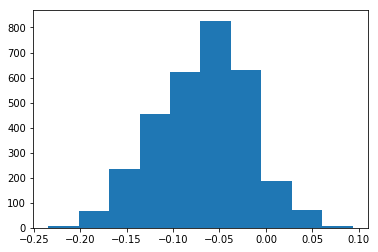

In [99]:
plt.hist(vitals_deltas_2016.dem_2016_delta)

In [100]:
keep_cols = ['dem_margin_2012', 'gop_margin_2012', 'ag_forest_fish_hunt_mine_rate_12-16_delta', 'armed_forces_pct_12-16_delta']

In [101]:
keep_frame = vitals_deltas_2016[keep_cols]

In [102]:
keep_frame.columns

Index(['dem_margin_2012', 'gop_margin_2012',
       'ag_forest_fish_hunt_mine_rate_12-16_delta',
       'armed_forces_pct_12-16_delta'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F978C6BBA8>,
      dtype=object)

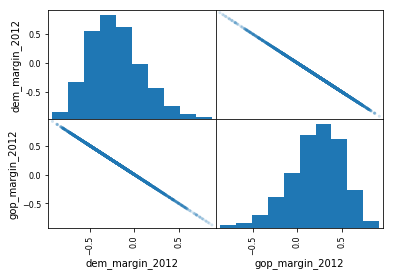

In [103]:
scatter_matrix(keep_frame, alpha = 0.2, diagonal = "hist")

In [104]:
keep_frame['ag_forest_fish_hunt_mine_rate_12-16_delta'] = keep_frame['ag_forest_fish_hunt_mine_rate_12-16_delta'].astype(float)
keep_frame['armed_forces_pct_12-16_delta'] = keep_frame['armed_forces_pct_12-16_delta'].astype(float)

C:\Users\cdept\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

C:\Users\cdept\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

C:\Users\cdept\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

C:\Users\cdept\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

C:\Users\cdept\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecati

<Figure size 432x288 with 0 Axes>

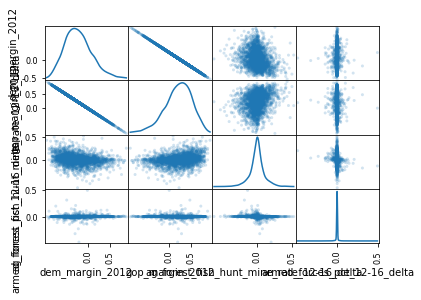

In [105]:
make_scatter_plot(keep_frame, "test")

## Predicting change in winner (classification)

### Logistic Regression

In [106]:
np.random.seed(seed=42)

X = vitals_deltas_2016.drop(['fips_code', 'dem_2016_delta', 'gop_2016_delta', 'class_2016'], 1)
Y = vitals_deltas_2016['class_2016']
X = X.dropna(axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

logreg = LogisticRegression(C=0.1, solver='lbfgs', multi_class='multinomial')

logreg.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [107]:
logreg.score(X_train, Y_train)

0.7814508723599632

In [108]:
logreg_pred = logreg.predict(X_test)

In [109]:
logreg.score(X_test, Y_test)

0.7548179871520343

In [110]:
logreg_matrix = confusion_matrix(Y_test, logreg_pred)

Confusion matrix, without normalization
[[  1   0 163   0]
 [  0   0   4   0]
 [  0   0 704   0]
 [  0   0  62   0]]


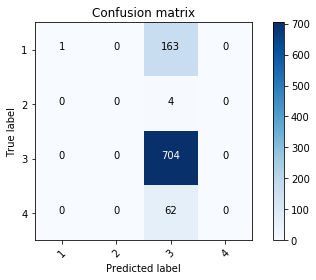

In [111]:
plot_confusion_matrix(logreg_matrix, classes = [1, 2, 3, 4])

In [112]:
np.argmax(logreg.coef_)

177

In [113]:
np.max(logreg.coef_)

0.08659072787796536

In [114]:
X_test.shape

(934, 46)

In [115]:
np.max(logreg.coef_[[1]])

0.08652959368608727

In [116]:
np.argmax(logreg.coef_[[1]])

39

In [117]:
print(logreg.coef_[[1]])

[[ 1.12436642e-04 -1.12436642e-04 -4.27738837e-07  1.68602361e-07
   2.61045312e-07 -2.31345644e-06 -1.66853078e-07 -1.88841379e-07
   7.84011573e-07  5.95222170e-07 -1.39631938e-06 -1.41038290e-05
  -2.99900792e-06  9.05561526e-06 -1.77481140e-06 -3.90903013e-04
  -8.60759038e-06 -4.98676707e-02 -4.98468675e-02 -3.79271766e-07
   1.21295947e-05  7.93329469e-06  7.29671617e-06  1.05079578e-06
  -3.53973496e-05 -1.28298703e-06 -5.37440299e-06 -6.65021487e-05
  -4.50865610e-05 -8.27564249e-06 -1.30770543e-05 -2.13526038e-05
  -3.46863073e-05 -4.39822729e-04 -4.25016434e-05 -2.92642665e-04
  -6.44565657e-05 -2.05972915e-02 -2.33471438e-03  8.65295937e-02
   8.64593763e-02 -6.01170714e-05 -2.22123232e-03 -3.50286740e-05
  -4.77000501e-05 -4.20688736e-04]]


In [118]:
X_test.columns

Index(['dem_margin_2012', 'gop_margin_2012',
       'ag_forest_fish_hunt_mine_rate_12-16_delta',
       'armed_forces_pct_12-16_delta', 'asian_pct_12-16_delta',
       'bachelor_deg_pct_12-16_delta', 'black_pct_12-16_delta',
       'foreign_born_citizen_12-16_delta',
       'foreign_born_noncitizen_12-16_delta', 'foreign_born_pct_12-16_delta',
       'graduate_deg_pct_12-16_delta', 'health_insurance_pct_12-16_delta',
       'hispanic_latino_pct_12-16_delta', 'lfp_rate_12-16_delta',
       'manufacturing_rate_12-16_delta', 'median_age_12-16_delta',
       'median_household_income_12-16_delta',
       'naturalized_citizen_pct_12-16_delta', 'non_citizen_pct_12-16_delta',
       'poverty_line_pct_12-16_delta', 'total_population_12-16_delta',
       'unemployment_rate_12-16_delta', 'veteran_pct_12-16_delta',
       'white_pct_12-16_delta', 'ag_forest_fish_hunt_mine_rate_2016',
       'armed_forces_pct_2016', 'asian_pct_2016', 'bachelor_deg_pct_2016',
       'black_pct_2016', 'foreign_born_c

In [119]:
logreg.coef_

array([[ 1.89702157e-04, -1.89702157e-04, -1.01411189e-05,
         5.03980182e-07,  4.86762376e-06,  6.09424541e-06,
         2.36138149e-05,  5.14192477e-06,  5.04988116e-06,
         1.01918112e-05,  7.59314924e-06, -6.35178371e-06,
         1.16771504e-05,  9.50981528e-06, -6.20469506e-06,
        -8.66710386e-04, -6.98736434e-08,  4.98571777e-02,
         4.98592991e-02,  3.79307311e-06,  1.12752009e-04,
         8.08025924e-06,  1.46714727e-07, -3.76531842e-05,
        -2.50868530e-05, -1.46880008e-07,  1.57779827e-06,
        -2.38505742e-05,  8.86117953e-06,  1.00177968e-06,
        -1.23372875e-06, -2.31915218e-07, -8.22379930e-06,
        -2.02515556e-04, -5.06578455e-06, -1.30221308e-04,
        -3.40871934e-05, -9.99864005e-03, -1.06848822e-03,
        -8.65070389e-02, -8.65464056e-02, -2.33569062e-05,
        -9.25657233e-04, -1.20816500e-05, -2.48053792e-05,
        -2.33246795e-04],
       [ 1.12436642e-04, -1.12436642e-04, -4.27738837e-07,
         1.68602361e-07,  2.61

### Random Forest Classifier

In [120]:
rfc = ensemble.RandomForestClassifier(random_state = 42)
X = vitals_deltas_2016.drop(['fips_code', 'dem_2016_delta', 'gop_2016_delta', 'class_2016'], 1)
Y = vitals_deltas_2016['class_2016']
X = X.dropna(axis=1)

In [121]:
X.head()

,dem_margin_2012,gop_margin_2012,ag_forest_fish_hunt_mine_rate_12-16_delta,armed_forces_pct_12-16_delta,asian_pct_12-16_delta,bachelor_deg_pct_12-16_delta,black_pct_12-16_delta,foreign_born_citizen_12-16_delta,foreign_born_noncitizen_12-16_delta,foreign_born_pct_12-16_delta,graduate_deg_pct_12-16_delta,health_insurance_pct_12-16_delta,hispanic_latino_pct_12-16_delta,lfp_rate_12-16_delta,manufacturing_rate_12-16_delta,median_age_12-16_delta,median_household_income_12-16_delta,naturalized_citizen_pct_12-16_delta,non_citizen_pct_12-16_delta,poverty_line_pct_12-16_delta,total_population_12-16_delta,unemployment_rate_12-16_delta,veteran_pct_12-16_delta,white_pct_12-16_delta,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016
0,-0.460580,0.460580,-0.0021006,-0.01,0,-0.002,0.004,0.0035,0.0005,0.004,0.031,0.007,0.002,-0.029,0.00522642,0.8,-0.005478,0.116,-0.116,0.02,0.003636,-0.03,-0.031,-0.02,0.0120978,0.007,0.008,0.143,0.185,0.008442,0.009558,0.018,0.103,0.911,0.026,0.602,0.139742,37.8,4.725086,0.469,0.531,0.094,4.740749,0.056,0.123,0.769
1,-0.558232,0.558232,-0.00268576,-0.001,0,0.006,0,0.002212,-0.006212,-0.004,0.012,0.027,0.001,-0.023,0.00700719,1.1,0.005608,0.104,-0.104,-0.003,0.036978,-0.022,-0.016,0,0.0146912,0.001,0.007,0.193,0.093,0.013497,0.019503,0.033,0.102,0.882,0.044,0.584,0.0939173,42.3,4.710667,0.409,0.591,0.093,5.299965,0.063,0.125,0.864
2,0.029147,-0.029147,0.0106332,0,-0.003,-0.007,0.019,0.003414,-0.002414,0.001,-0.009,0.039,-0.007,0.001,-0.0150734,0.5,0.027276,0.111,-0.111,-0.002,-0.013733,-0.007,-0.017,-0.023,0.0463395,0,0.005,0.078,0.479,0.008874,0.020126,0.029,0.051,0.87,0.043,0.48,0.22942,38.7,4.530917,0.306,0.694,0.2,4.425110,0.128,0.084,0.467
3,-0.468478,0.468478,0.0238341,0,0,0.002,-0.006,-0.002487,0.003487,0.001,0.028,0.058,0.004,-0.044,0.0277722,0.8,0.033490,-0.211,0.211,-0.014,-0.003774,-0.034,-0.022,0.003,0.0394928,0,0.001,0.062,0.212,0.003584,0.010416,0.014,0.058,0.91,0.022,0.486,0.213285,40.2,4.599621,0.256,0.744,0.117,4.353570,0.071,0.072,0.77
4,-0.741451,0.741451,-0.00175645,0,0,0.008,0.003,0.004383,-0.008383,-0.004,-0.002,0.019,0.006,-0.083,-0.0220508,1.7,0.009693,0.117,-0.117,0.013,0.001795,-0.04,0.003,0.005,0.0290867,0,0.002,0.089,0.016,0.011997,0.031003,0.043,0.041,0.888,0.087,0.499,0.157471,40.8,4.664755,0.279,0.721,0.122,4.761206,0.06,0.101,0.954


In [122]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [123]:
rfc.fit(X_train, Y_train)

C:\Users\cdept\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [124]:
train_predictions = rfc.predict(X_train)
cm_train = confusion_matrix(Y_train, train_predictions)
print(cm_train)

[[ 300    0    0    3]
 [   0   15    1    0]
 [   0    0 1702    0]
 [   6    0    0  151]]


In [125]:
np.sum(sum((np.eye(4) * cm_train)), axis=0) / np.sum(sum(cm_train), axis=0)

0.9954086317722681

In [126]:
test_predictions = rfc.predict(X_test)
cm_test = confusion_matrix(Y_test, test_predictions)
print(cm_test)

[[152   0   0  12]
 [  0   0   4   0]
 [  0   0 704   0]
 [ 23   0   0  39]]


In [127]:
np.sum(sum((np.eye(4) * cm_test)), axis=0) / np.sum(sum(cm_test), axis=0)

0.9582441113490364

In [128]:
rfc.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [129]:
rfc_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 3)],
            'max_depth': [100],
            'max_features': ['sqrt','log2'],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [5, 10, 15],
            'bootstrap': [True, False]}

In [130]:
pprint(rfc_grid, indent = 2)

{ 'bootstrap': [True, False],
  'max_depth': [100],
  'max_features': ['sqrt', 'log2'],
  'min_samples_leaf': [3, 4, 5],
  'min_samples_split': [5, 10, 15],
  'n_estimators': [1000, 1500, 2000]}


In [131]:
# rfc_gridsearch = GridSearchCV(rfc, param_grid = rfc_grid, cv = 5, n_jobs = 4)
# start = time()
# rfc_gridsearch.fit(X_train, Y_train)

# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time() - start, len(rfc_gridsearch.cv_results_['params'])))
# report(rfc_gridsearch.cv_results_)

In [132]:
rfc_params = {'bootstrap': False, 
              'max_depth': 100, 
              'max_features': 'sqrt', 
              'min_samples_leaf': 3, 
              'min_samples_split': 5, 
              'n_estimators': 1000}

In [133]:
rfc_optimal = ensemble.RandomForestClassifier(**rfc_params)

In [134]:
rfc_optimal.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
rfc_matrix = confusion_matrix(Y_test, rfc_optimal.predict(X_test))

Confusion matrix, without normalization
[[157   0   0   7]
 [  0   0   4   0]
 [  0   0 704   0]
 [ 23   0   0  39]]
0.9635974304068522


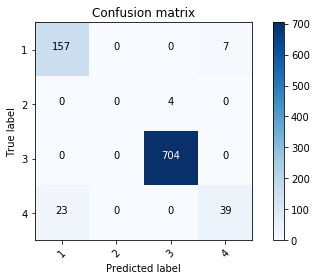

In [136]:
plot_confusion_matrix(rfc_matrix, classes = [1, 2, 3, 4])
print(accuracy_score(Y_test, rfc_optimal.predict(X_test)))

### XGBoost classification

In [137]:
import xgboost as xgb

In [138]:
label_train = Y_train.values
label_train = label_train - 1

In [139]:
label_test = Y_test.values
label_test = label_test - 1

In [140]:
X_train.columns.values

array(['dem_margin_2012', 'gop_margin_2012',
       'ag_forest_fish_hunt_mine_rate_12-16_delta',
       'armed_forces_pct_12-16_delta', 'asian_pct_12-16_delta',
       'bachelor_deg_pct_12-16_delta', 'black_pct_12-16_delta',
       'foreign_born_citizen_12-16_delta',
       'foreign_born_noncitizen_12-16_delta',
       'foreign_born_pct_12-16_delta', 'graduate_deg_pct_12-16_delta',
       'health_insurance_pct_12-16_delta',
       'hispanic_latino_pct_12-16_delta', 'lfp_rate_12-16_delta',
       'manufacturing_rate_12-16_delta', 'median_age_12-16_delta',
       'median_household_income_12-16_delta',
       'naturalized_citizen_pct_12-16_delta',
       'non_citizen_pct_12-16_delta', 'poverty_line_pct_12-16_delta',
       'total_population_12-16_delta', 'unemployment_rate_12-16_delta',
       'veteran_pct_12-16_delta', 'white_pct_12-16_delta',
       'ag_forest_fish_hunt_mine_rate_2016', 'armed_forces_pct_2016',
       'asian_pct_2016', 'bachelor_deg_pct_2016', 'black_pct_2016',
       '

In [141]:
dtrain = xgb.DMatrix(X_train.values, label = label_train, feature_names = X_train.columns.values)
dtest = xgb.DMatrix(X_test.values, label = label_test, feature_names = X_test.columns.values)

In [142]:
param = {'max_depth': 5, 'eta': 0.1, 'silent': 1, 'objective': 'multi:softmax', 'num_class': 4}
param['nthread'] = 4
param['eval_metric'] = 'merror'

In [143]:
eta_vals = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
depth_vals = [2, 5, 10, 15, 30, 40, 50]
lambda_vals = [10, 1, 0.1, 0.01, 0.001]
colsample_bytree_vals = [0.5, 0.6, 0.7, 0.8, 0.9]

In [144]:
search_matrix = np.zeros((len(eta_vals), len(depth_vals), len(lambda_vals), len(colsample_bytree_vals)))

In [145]:
watchlist = [(dtest, 'test'), (dtrain, 'train')]

In [146]:
num_round = 50
bst = xgb.train(param, dtrain, num_round, watchlist, verbose_eval=50)

[0]	test-merror:0.049251	train-merror:0.018365
[49]	test-merror:0.043897	train-merror:0.000459


In [91]:
for eta_num, eta in enumerate(eta_vals):
    param['eta'] = eta
    for depth_num, depth in enumerate(depth_vals):
        param['max_depth'] = depth
        for lambda_num, lambd in enumerate(lambda_vals):
            param['lambda'] = lambd
            for bytree_num, bytree in enumerate(colsample_bytree_vals):
                param['colsample_bytree'] = bytree
                bst_loop = xgb.train(param, dtrain, num_round, watchlist, verbose_eval=False)
                error_rate = 1 - (sum(bst_loop.predict(dtest) == label_test) / len(label_test))
                search_matrix[eta_num, depth_num, lambda_num, bytree_num] = error_rate

In [147]:
np.unravel_index(np.argmin(search_matrix, axis=None), search_matrix.shape)

(0, 0, 0, 0)

In [148]:
search_matrix[0, 3, 2, 1]

0.0

In [149]:
found_params = {'max_depth': depth_vals[3], 'eta': eta_vals[0], 'silent': 1, 'objective': 'multi:softmax', 
                'num_class': 4, 'lambda': lambda_vals[2], 'colsample_bytree': colsample_bytree_vals[1],
               'nthread': 4, 'eval_metric': 'merror'}

In [150]:
num_round = 50
bst_found = xgb.train(found_params, dtrain, num_round, watchlist, verbose_eval=50)

[0]	test-merror:0.063169	train-merror:0.008264
[49]	test-merror:0.040685	train-merror:0


In [151]:
found_matrix = confusion_matrix(label_test, bst_found.predict(dtest))

In [156]:
plot_confusion_matrix(found_matrix)


TypeError: plot_confusion_matrix() missing 1 required positional argument: 'classes'

<Figure size 640x480 with 0 Axes>

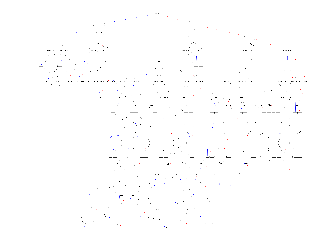

In [154]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_tree(bst_found)

ImportError: You must install graphviz to plot tree

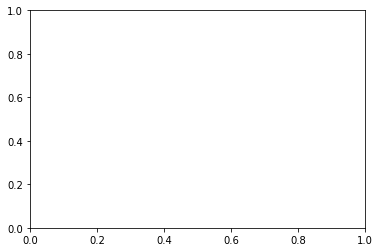

In [164]:
xgb.plot_tree(bst_found)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

Confusion matrix, without normalization
[[151   0   0  13]
 [  0   0   4   0]
 [  0   0 704   0]
 [ 16   0   0  46]]


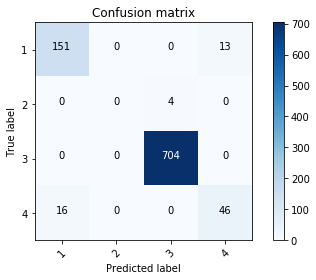

In [98]:
plot_confusion_matrix(found_matrix, classes = [1, 2, 3, 4])

Confusion matrix, without normalization
[[152   0   0  12]
 [  0   0   4   0]
 [  0   0 704   0]
 [ 23   0   0  39]]


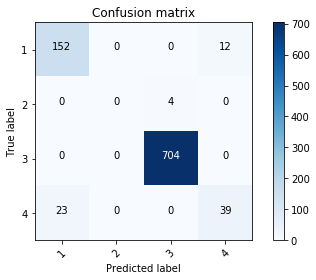

In [99]:
plot_confusion_matrix(cm_test, classes = [1,2,3,4])

In [100]:
features_importances = bst_found.get_score(importance_type="gain")
sorted(features_importances.values())

[0.16273841445454545,
 0.16609636804545455,
 0.26932045415263167,
 0.31456018201944447,
 0.35554475515199996,
 0.35825026656699993,
 0.3620149121971874,
 0.36608813476499996,
 0.3849902669591305,
 0.40979966561500003,
 0.40995253825789474,
 0.4123834131,
 0.4388568952975862,
 0.4590498169473683,
 0.4701116215299999,
 0.47541013113809527,
 0.47835735765263143,
 0.48444702340740725,
 0.48884053975172426,
 0.496207197269375,
 0.5078441090750001,
 0.5200131460136362,
 0.5213193184526317,
 0.5322583077804168,
 0.5484681550557144,
 0.5512533551785715,
 0.5649745895310258,
 0.6158841501125001,
 0.6748393184674999,
 0.6842158507462962,
 0.6996197791109092,
 0.7016439566787501,
 0.7055148654508332,
 0.712796233965,
 0.750025638120606,
 0.7521514672135902,
 0.755276341367037,
 0.7780673632727274,
 0.803421182422,
 0.8682000737871431,
 0.9323049682096772,
 1.154563677178572,
 1.1891581619194447,
 1.4253452269397497,
 6.575255097435381,
 21.83784991144324]

In [1]:
features_importances

NameError: name 'features_importances' is not defined

### Random Forest Regression

In [79]:
rfr = ensemble.RandomForestRegressor(random_state = 42)
X2 = vitals_deltas_2016.drop(['fips_code', 'dem_2016_delta', 'class_2016'] , 1)
Y2 = vitals_deltas_2016['dem_2016_delta']
# X2 = X.dropna(axis=1)

In [80]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.30, random_state=42)

In [81]:
X_train2.shape

(2178, 47)

In [82]:
X_train.head()

,dem_margin_2012,gop_margin_2012,ag_forest_fish_hunt_mine_rate_12-16_delta,armed_forces_pct_12-16_delta,asian_pct_12-16_delta,bachelor_deg_pct_12-16_delta,black_pct_12-16_delta,foreign_born_citizen_12-16_delta,foreign_born_noncitizen_12-16_delta,foreign_born_pct_12-16_delta,graduate_deg_pct_12-16_delta,health_insurance_pct_12-16_delta,hispanic_latino_pct_12-16_delta,lfp_rate_12-16_delta,manufacturing_rate_12-16_delta,median_age_12-16_delta,median_household_income_12-16_delta,naturalized_citizen_pct_12-16_delta,non_citizen_pct_12-16_delta,poverty_line_pct_12-16_delta,total_population_12-16_delta,unemployment_rate_12-16_delta,veteran_pct_12-16_delta,white_pct_12-16_delta,ag_forest_fish_hunt_mine_rate_2016,armed_forces_pct_2016,asian_pct_2016,bachelor_deg_pct_2016,black_pct_2016,foreign_born_citizen_2016,foreign_born_noncitizen_2016,foreign_born_pct_2016,graduate_deg_pct_2016,health_insurance_pct_2016,hispanic_latino_pct_2016,lfp_rate_2016,manufacturing_rate_2016,median_age_2016,median_household_income_2016,naturalized_citizen_pct_2016,non_citizen_pct_2016,poverty_line_pct_2016,total_population_2016,unemployment_rate_2016,veteran_pct_2016,white_pct_2016
1740,0.127214,-0.127214,-0.0293069,-0.001,0.03,0.117,0.008,0.032622,0.018378,0.051,0.051,0.008,0,0.035,-0.0443125,-1,0.097550,0.15,-0.15,0.002,0.601567,-0.005,-0.029,-0.019,0.00484723,0.001,0.037,0.233,0.024,0.047502,0.043498,0.091,0.129,0.918,0.06,0.701,0.14286,40.3,4.864446,0.522,0.478,0.058,5.607399,0.052,0.089,0.907
907,-0.201594,0.201594,0.104882,0,-0.005,-0.069,0.007,0.000576,0.007424,0.008,-0.087,0.015,0.025,0.014,-0.037732,12.7,0.055985,-0.039,0.039,-0.055,-1.171064,-0.026,-0.007,0.016,0.14948,0,0.014,0.184,0.014,0.012816,0.035184,0.048,0.089,0.911,0.06,0.65,0.0175859,40.8,4.652208,0.267,0.733,0.054,3.401401,0.039,0.069,0.946
2725,0.054402,-0.054402,0.00644349,0.034,-0.004,0.037,-0.056,0.083035,0.059965,0.143,0.011,-0.068,0.697,-0.06,-0.190155,-4.9,0.047049,0.323,-0.323,0.033,0.035180,-0.022,0.003,0.062,0.0438413,0.035,0.004,0.125,0.014,0.089571,0.129429,0.219,0.05,0.772,0.809,0.552,0.0651357,31.6,4.645127,0.409,0.591,0.171,4.688971,0.084,0.095,0.925
2686,-0.407371,0.407371,-0.199578,0,-0.001,-0.036,0.174,-0.007623,0.011623,0.004,-0.009,-0.1,0.066,-0.133,0.159991,-3.5,-0.112780,-0.497,0.497,0.034,0.564632,0.054,-0.041,-0.205,0.0569208,0,0,0.105,0.174,0.010465,0.012535,0.023,0.029,0.817,0.072,0.504,0.203319,45.8,4.544267,0.455,0.545,0.129,4.095344,0.069,0.077,0.792
3008,-0.411802,0.411802,0.06748,0,0.001,-0.006,-0.023,-0.00992,-0.02408,-0.034,0.028,0.144,-0.072,-0.022,-0.0675228,2,-0.015388,0.602,-0.602,0.031,-0.200213,-0.013,-0.058,0.083,0.0940344,0,0.005,0.077,0.004,0.006,0,0.006,0.065,0.914,0.007,0.555,0.0674082,47.9,4.638779,1,0,0.087,3.840232,0.082,0.097,0.981


In [83]:
rfr.fit(X_train2, Y_train2)

/home/jcdepth/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [84]:
rfr.feature_importances_

array([8.77533936e-01, 1.71831808e-02, 1.45689041e-02, 1.76593568e-03,
       7.32968624e-04, 5.45098575e-04, 8.34074572e-04, 4.14545125e-03,
       1.47356120e-03, 7.91776349e-04, 1.15332434e-03, 8.57851149e-04,
       1.39217969e-03, 1.45462299e-03, 1.04995945e-03, 1.03495406e-03,
       9.56692885e-04, 7.29459214e-04, 1.12606427e-03, 6.96449384e-04,
       1.10007199e-03, 1.10625974e-03, 1.01308179e-03, 3.32680121e-03,
       2.92867222e-03, 2.06517481e-03, 3.78623157e-04, 7.98547305e-04,
       2.43087051e-03, 2.10403629e-02, 3.89116652e-03, 1.16797549e-03,
       1.97659477e-03, 1.35290621e-03, 6.73672985e-03, 1.60397178e-03,
       2.02060767e-03, 1.67462231e-03, 1.21543221e-03, 2.96301839e-03,
       5.37425984e-04, 6.42350375e-04, 1.39464103e-03, 1.52825922e-03,
       2.37149345e-03, 1.44882927e-03, 1.25906516e-03])

In [85]:
rfr.score(X_train2, Y_train2)

0.9876249009978639

In [86]:
rfr.score(X_test2, Y_test2)

0.9339790236264235

In [87]:
train_predictions = rfr.predict(X_train2)
errors = sum((train_predictions - Y_train2)**2)/len(train_predictions)
print(errors)

2.993974377680084e-05


In [88]:
test_predictions = rfr.predict(X_test2)
errors = sum((test_predictions - Y_test2)**2)/len(test_predictions)
print(errors)

0.00016727697473172708


In [89]:
X_test.shape

(934, 46)

In [90]:
rfr_params = {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1500}

In [91]:
rfr_optimal = ensemble.RandomForestRegressor(**rfr_params)

In [92]:
rfr_optimal.fit(X_train2, Y_train2)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [93]:
train_predictions = rfr_optimal.predict(X_train2)
errors = sum((train_predictions - Y_train2)**2)/len(train_predictions)
print(errors)

2.9974027037176295e-05


In [94]:
train_predictions = rfr_optimal.predict(X_test2)
errors = sum((train_predictions - Y_test2)**2)/len(train_predictions)
print(errors)

0.00036594607039178265


In [95]:
0.0011170903115024866 / 7.850851310208487e-05

14.228906743526407

In [96]:
print(rfr_optimal.score(X_train2, Y_train2))
print(rfr_optimal.score(X_test2, Y_test2))

0.9876107305779557
0.8555681862008435


(array([  7.,  69., 233., 456., 624., 827., 630., 186.,  73.,   7.]),
 array([-0.23444993, -0.20165923, -0.16886854, -0.13607784, -0.10328715,
        -0.07049645, -0.03770576, -0.00491506,  0.02787563,  0.06066633,
         0.09345702]),
 <a list of 10 Patch objects>)

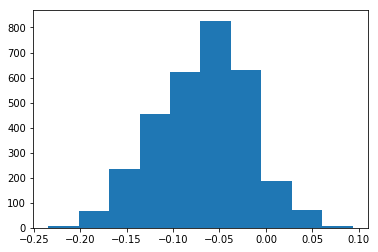

In [97]:
plt.hist(vitals_deltas_2016.dem_2016_delta)

In [99]:
keep_cols = ['dem_margin_2012', 'gop_margin_2012', 'ag_forest_fish_hunt_mine_rate_12-16_delta', 'armed_forces_pct_12-16_delta']

In [100]:
keep_frame = vitals_deltas_2016[keep_cols]

In [101]:
keep_frame.columns

Index(['dem_margin_2012', 'gop_margin_2012',
       'ag_forest_fish_hunt_mine_rate_12-16_delta',
       'armed_forces_pct_12-16_delta'],
      dtype='object')

In [102]:
import pylab
from pandas.tools.plotting import scatter_matrix

/home/jcdepth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf029ada90>,
      dtype=object)

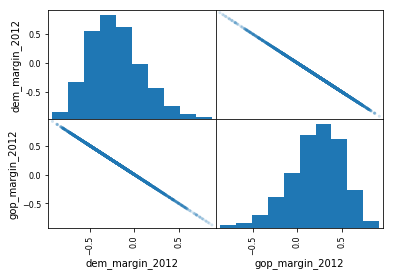

In [103]:
scatter_matrix(keep_frame, alpha = 0.2, diagonal = "hist")

In [104]:
import plotly

In [105]:
keep_frame['ag_forest_fish_hunt_mine_rate_12-16_delta'] = keep_frame['ag_forest_fish_hunt_mine_rate_12-16_delta'].astype(float)
keep_frame['armed_forces_pct_12-16_delta'] = keep_frame['armed_forces_pct_12-16_delta'].astype(float)


In [106]:
keep_frame.dtypes

dem_margin_2012                              float64
gop_margin_2012                              float64
ag_forest_fish_hunt_mine_rate_12-16_delta    float64
armed_forces_pct_12-16_delta                 float64
dtype: object

In [87]:
make_scatter_plot(keep_frame, "test")

NameError: name 'keep_frame' is not defined

### XGB Regression

In [84]:
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10)

In [87]:
xgb_reg.fit(X_train, Y_train)
reg_preds = xgb_reg.predict(dtrain)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields ag_forest_fish_hunt_mine_rate_12-16_delta, armed_forces_pct_12-16_delta, asian_pct_12-16_delta, bachelor_deg_pct_12-16_delta, black_pct_12-16_delta, foreign_born_citizen_12-16_delta, foreign_born_noncitizen_12-16_delta, foreign_born_pct_12-16_delta, graduate_deg_pct_12-16_delta, health_insurance_pct_12-16_delta, hispanic_latino_pct_12-16_delta, lfp_rate_12-16_delta, manufacturing_rate_12-16_delta, median_age_12-16_delta, naturalized_citizen_pct_12-16_delta, non_citizen_pct_12-16_delta, poverty_line_pct_12-16_delta, unemployment_rate_12-16_delta, veteran_pct_12-16_delta

In [88]:
X_train.values

array([[0.1272141304619382, -0.1272141304619382, -0.029306860260123847,
        ..., 0.6015669352313004, -0.0049999999999999975,
        -0.028999999999999998],
       [-0.2015935247249273, 0.2015935247249273, 0.1048816930904041, ...,
        -1.1710644458106434, -0.026000000000000002,
        -0.006999999999999992],
       [0.05440199335548168, -0.05440199335548168, 0.006443490146243999,
        ..., 0.03518005198286822, -0.021999999999999992,
        0.0030000000000000027],
       ...,
       [0.2631379604204147, -0.2631379604204147, -0.054055760792877314,
        ..., 0.017032534342421357, 0.057, -0.03199999999999999],
       [-0.1305348258706468, 0.1305348258706468, -0.14302545913812598,
        ..., 1.2914922585284656, -0.008, -0.067],
       [-0.20772426527158028, 0.20772426527158028, 0.12426142454038383,
        ..., -0.9401439012185566, -0.094, -0.023000000000000007]],
      dtype=object)